# Quantum Convolutional Neural Network

## Introduction

This project implements a simplified Quantum Convolutional Neural Network (QCNN), a quantum analogue to a classical convolutional neural network. Convolutional neural networks are used in a variety of application fields, a.o. in remote sensing, which is the classification of satellite images to detect natural phenomena and suspicious activities.

This project follows the work of Iris Cong, Soonwon Choi and Mikhail D Lukin (https://arxiv.org/abs/1810.03787). They showed that this QCNN makes use of only O(log N) parameters for input sizes of N qubits, instead of O(N) parameters in the classical algorithm. This allows for an efficient training and implementation on quantum devices.

This work is also inspired by the implementation of QCNN using the Cirq API, as described in https://www.tensorflow.org/quantum/tutorials/qcnn.

The neural network is translationally invariant and is used to detect certain properties of a quantum data source, such as a quantum sensor or a complex simulation from a device. 

The quantum data source is a cluster state that may or may not have an excitation, which is what the QCNN will learn to detect. The cluster state model is an alternative to the quantum circuit model for the representation of quantum computations. This model is used in the computations in this neural network. The cluster state is highly entangled. The goal of the project is to prepare a cluster state, and to train a quantum classifier to detect if it is "excited" or not. 

Excitations are represented with Rx gates, which represent rotations around the X axis. A large enough rotation is deemed an excitation and is labeled 1 and a rotation that isn't large enough is labeled -1 and deemed not an excitation.

The architecture of the classifier is as follows:

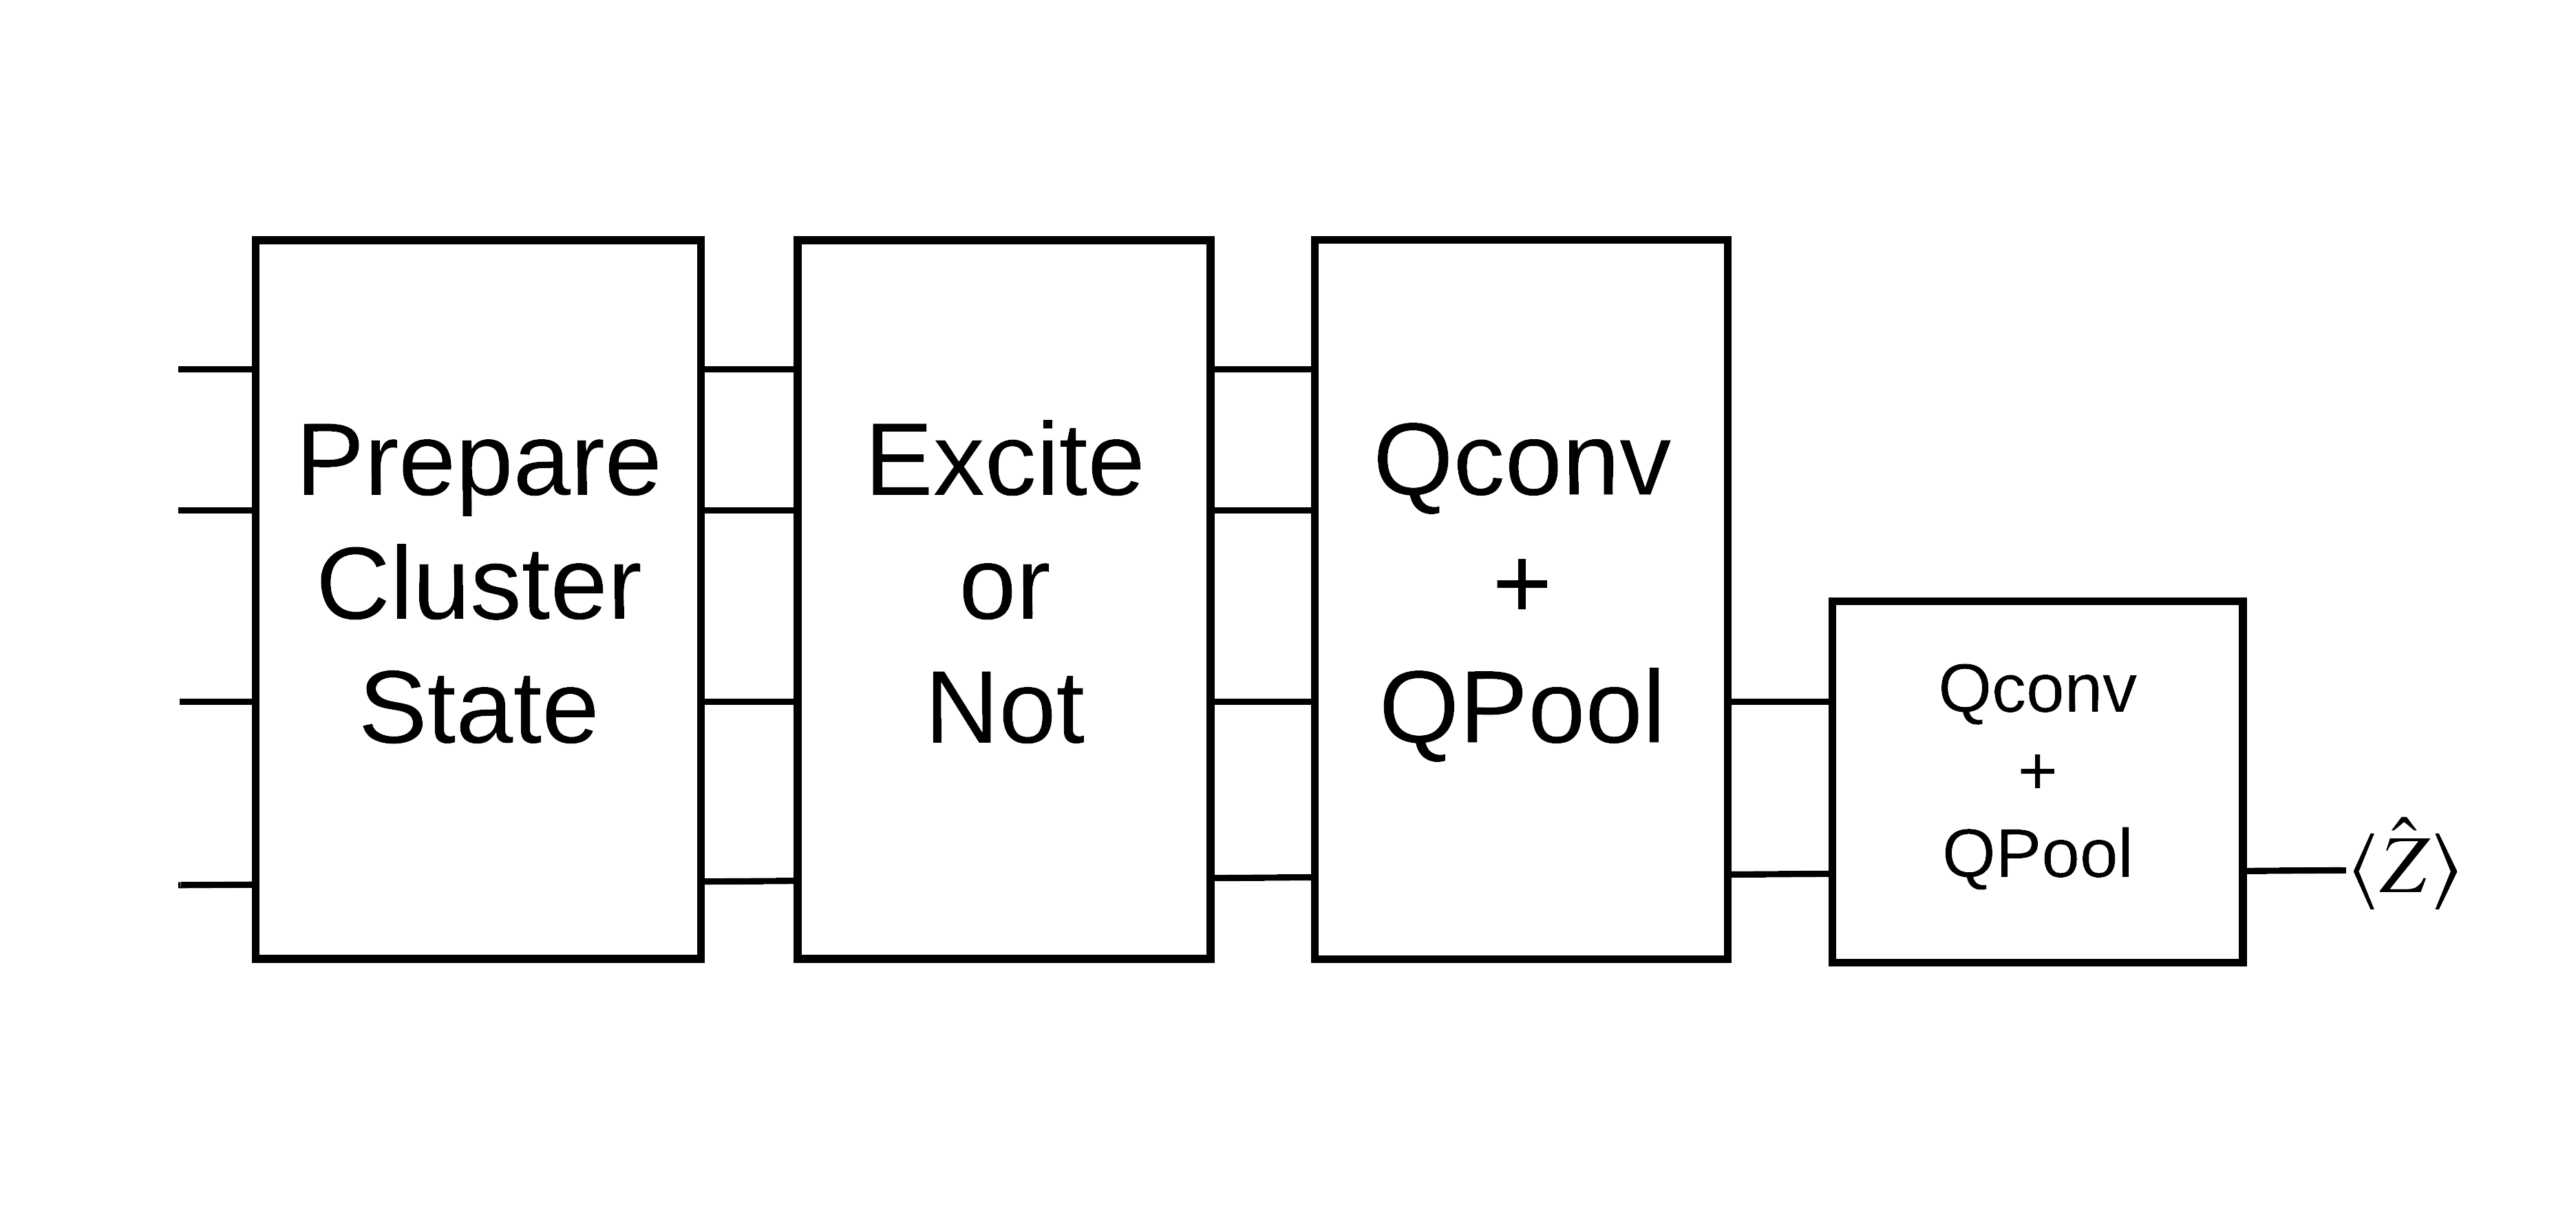

The data preparation consists of:

* Define cluster state
* Generate cluster state data, which may be excited

The sequence of layers is:

* Perform a quantum convolution on the cluster state data
* Perform a quantum pooling to reduce the number of qubits. This pooling is attained by reducing the entanglement, so you can pool two qubits into one.
* Perform the previous two steps in a loop, until you only have one qubit left over

**Remark:**
* Due to the lack of time we haven't been able to actually implement the qcnn and see how it works, but we managed to reverse engineer tensorflow's qcnn tutorial and recode the necessary quantum parts of qcnn in qiskit.
* This notebook contains the functions developed for this purpose.
* It basically reproduces tensorflow's tutorial up to the end of part 1.5 of google's notebook.


## Setup

First import qiskit, numpy and sympy

In [1]:
import numpy as np

# Importing necessary quantum computing library (QISKIT)
import qiskit
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.visualization import *

## Definition of the cluster state

The cluster state model is an alternative to the quantum circuit model for the representation of quantum computations. This model is used in the computations in this neural network. The first step of the computation is to define the cluster state.

In [2]:
# Source:https://www.tensorflow.org/quantum/tutorials/qcnn
def cluster_state(qr):
    """Returns a cluster state of the qubits in the quantum register `qr`
    
    Parameters
    ----------
    
    qr: (QuantumRegister)
        Qiskit quantum register
    
    Returns
    -------
    
    qc: (QuantumCircuit)
        Qiskit quantum circuit with the cluster state
    """
    qc = QuantumCircuit(qr) # Creating a QuantumRegister
    
    # Applying a Hadamard gate to qubits
    for i, _ in enumerate(qr): 
        qc.h(i)
        
    for this_bit, next_bit in zip(qr, qr[1:] + [qr[0]]):
        c = this_bit.index
        t = next_bit.index
        qc.cz(c, t)
    return qc

In [3]:
qc_cs = cluster_state(QuantumRegister(4))

/tmp/ipykernel_5908/1889944956.py:24: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  c = this_bit.index
/tmp/ipykernel_5908/1889944956.py:25: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  t = next_bit.index


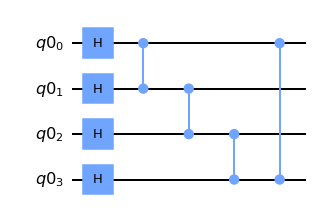

In [4]:
qc_cs.draw('mpl')

## Data generation

Before implementing the layers, we need to generate the data. In this case it's going to be excitations to the cluster state. As mentioned above, excitations are represented with Rx gates, which represent rotations around the X axis. A large enough rotation is deemed an excitation and is labeled 1 and a rotation that isn't large enough is labeled -1 and deemed not an excitation.

In [5]:

# https://www.tensorflow.org/quantum/tutorials/qcnn
# This function is a readaptation of the tensorflow tutorial using qiskit and pytorch instead
# WARNING: I believe the function is working, but it looks like it is not possible to convert quantum gates
# and quantum circuits to pytorch tensors.
# I don't think there is an equivalent of tfq.convert_to_tensor yet.
# For the moment the function only returns a tuple of lists for train and test excitations.
def generate_data(qubits):
    """Generate training and testing data.
    Parameters
    ----------
    
    qubits: (Qiskit QuantumRegister)
        Quantum register containing qubits to pass to the Quantum circuit
        
    Returns
    --------
    train_excitations: (list)
        list of excited qubits for training
        
    train_labels: (array)
        numpy array containing the labels corresponding to the train set
        
    test_excitations: (list)
        list of excited qubits to use as a testing set
        
    test_labels: (array)
        numpy array containing the labels of the test set
        
    N.B. train_excitations and test_excitations should be a PyTorch tensor   
    """
    n_rounds = 20  # Produces n_rounds * n_qubits datapoints.
    excitations = []
    labels = []
    for n in range(n_rounds):
        for bit in qubits:
            rng = np.random.uniform(-np.pi, np.pi)
            # Creating a quantum circuit with qiskit
            excitations.append(QuantumCircuit(bit.register).rx(rng, bit.register))
            #excitations.append(cirq.Circuit(cirq.rx(rng)(bit))) / cirq to check if it's correct
            labels.append(1 if (-np.pi / 2) <= rng <= (np.pi / 2) else -1)

    split_ind = int(len(excitations) * 0.7)
    train_excitations = excitations[:split_ind]
    test_excitations = excitations[split_ind:]

    train_labels = labels[:split_ind]
    test_labels = labels[split_ind:]
    
    return train_excitations, np.array(train_labels), \
        test_excitations, np.array(test_labels)


In [6]:
qr = QuantumRegister(2)
train_excitations, train_labels, test_excitations, test_labels = generate_data(qr)

/tmp/ipykernel_5908/2187829483.py:38: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  excitations.append(QuantumCircuit(bit.register).rx(rng, bit.register))


# Implementation of layers

## QCNN layers

The quantum convolution and pooling layers of the neural network will be implemented using one-qubit and two-qubit unitary matrices. These unitary matrices are described in a paper by Robert R Tucci (https://arxiv.org/abs/quant-ph/0507171), and are implemented below.


### One Qubit Unitary Matrix

**Remarks concerning the use of parameters:**

- One of the main issues faced while developing these functions was to take into consideration the parameters required for the rotation operators.
- Due to the growing complexity of the circuit developped below, it became growingly difficult to handle these parameters without an in-depth knowledge of the `Parameter` object of qiskit.
- It is possible to overload these parameters with the use of the `.to_instruction()` method of `QuantumCircuit` objects.
- **But for the sake of speed of development and a certain lack of time, some temporary workarounds have been adopted.**
- In the three functions `one_qubit_unitary`, `two_qubit_unitary`, `two_qubit_pool` a **rotation** argument has been added.
    - The **rotation** argument is a dictionary containing several tuples of size three corresponding to the values of z, y and x that are the values needed for the rotation operators. The number of tuples depends on the number of qubits to rotate.
- Because of the great number of operations involving rotations in functions `quant_conv_circuit` and `quant_pool_circuit`, a temporary solution has been adopted. It consists in generating a new tuple with updated values at every round of iteration for all qubits involved. These rotation values take a different name based on the round number of the iteration.
- These workarounds might make the code a bit less clear (and maybe less *pythonic*) but it avoided circuit errors due to identical names in the circuit.
- Naturally this is a temporary solution that allowed us to create the needed circuits for the sake of demonstration but it will need further investigation and improvements in the future.
- N.B. a discussion about parameters handling in qiskit would be welcomed.

In [7]:
# Source of the function: https://www.tensorflow.org/quantum/tutorials/qcnn
# The function has been re-adapted for qiskit use
from qiskit.circuit import Parameter
def one_qubit_unitary(bit, rotation=('1', '2', '3')):
    """Make a circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    
    Parameters
    -----------
    bit: (QuantumRegister (qubit)) 
        qubit to rotate
        
    rotation: (tuple) 
        tuple containing the three rotation values of rotation operators for respectively, x, y and z
        
    Returns
    -------
        Rotated qubit, one qubit unitary matrix
    """
    x, y, z = rotation
    qc = QuantumCircuit(bit)
    qc.rx(Parameter(x), 0)
    qc.ry(Parameter(y), 0)
    qc.rz(Parameter(z), 0)
    return qc

In [8]:
one_qubit_unitary(1, ("e1", "e2", "e3")).draw()

/home/ialaouiamini/Documents/MSIAM_courses/quantum_computing_hackathon/.qvenv/lib/python3.8/site-packages/sympy/core/expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


┌────────┐┌────────┐┌────────┐
q_0: ┤ Rx(e1) ├┤ Ry(e2) ├┤ Rz(e3) ├
     └────────┘└────────┘└────────┘

### Two Qubit Unitary Matrix

In [9]:
# Function still needs some rechecking but it might be correct.
# replace symbols later, still having an issue with symbols
def two_qubit_unitary(bits, 
                      rotations={"q1": ("x1", "y1", "z1"), 
                                "q2": ('x2', 'y2', 'z2'), 
                                "rzyx":("t1", "t2", "t3")}): 
    """Make a qiskit circuit that creates an arbitrary two qubit unitary.
    
    Parameters
    ----------
    bits: (QuantumRegister)
        Qiskit quantum register which we want to pass to the circuit
    
    rotations: (dictionary)
        dictionary containing the rotation parameters for both qubits and x, y, z axis
    
    Returns
    -------
    big_qc: (QuantumCircuit)
        Qiskit quantum circuit representing two-qubit unitary matrix (to be confirmed)
    """
    
    rot1 = rotations["q1"]
    rot2 = rotations["q2"]
    sub_circ1 = one_qubit_unitary(1, rot1)
    sub_circ2 = one_qubit_unitary(1, rot2)

    qr = bits
    big_qc = QuantumCircuit(qr)
    big_qc.append(sub_circ1.to_instruction(), [qr[0]])
    big_qc.append(sub_circ2.to_instruction(), [qr[1]])
    
    zz, yy, xx = rotations["rzyx"]
    big_qc.rzz(Parameter(zz), 0, 1)
    big_qc.ryy(Parameter(yy), 0, 1)
    big_qc.rxx(Parameter(xx), 0, 1)
    
    big_qc.append(sub_circ1.to_instruction(), [qr[0]])
    big_qc.append(sub_circ2.to_instruction(), [qr[1]])
    
    return big_qc

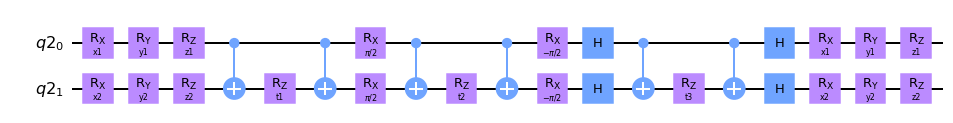

In [10]:
two_qubit_unitary(QuantumRegister(2)).decompose().draw('mpl')

### Two Qubit Pooling

This is the operation which attempts to reduce entanglement so we reduce two qubits to one.

In [11]:
# source: https://www.tensorflow.org/quantum/tutorials/qcnn
def two_qubit_pool(source_qubit, sink_qubit, 
                   rotations={"q1":("x1", "y1", "z1"), 
                              "q2": ("x2", "y2", "z2"), 
                              "invq":("-x", "-y", "-z")}): # add symbols later
    """Make a Qiskit circuit to do a parameterized 'pooling' operation, which
    attempts to reduce entanglement down from two qubits to just one.
    
    Parameters
    ---------
    
    source_qubit: (QuantumRegister)
        source qubit that wil be the control qubit before sinking
    
    sink_qubit: (QuantumRegister)
        sink_qubit that will be the target qubit of the cnot gate and that is supposed to be inversed
    
    Returns
    ------
    pool_circuit: (QuantumCircuit)
        Qiskit quantum circuit making the pooling operation
    """
    
    rot1 = rotations["q1"]
    rot2 = rotations["q2"]
    sink_basis_selector = one_qubit_unitary(sink_qubit, rot1)
    source_basis_selector = one_qubit_unitary(source_qubit, rot2)
    
    qr = QuantumRegister(2)
    pool_circuit = QuantumCircuit(qr)
    pool_circuit.append(sink_basis_selector.to_instruction(), [qr[0]])
    pool_circuit.append(source_basis_selector.to_instruction(), [qr[1]])
    pool_circuit.cnot(control_qubit=0, target_qubit=1)
    
    # add sink_basis selector I don't know what is being done
    inv_rot = rotations["invq"]
    inv_sink_basis_selector = one_qubit_unitary(source_qubit, inv_rot)
    pool_circuit.append(inv_sink_basis_selector.to_instruction(), [qr[1]])
    
    return pool_circuit

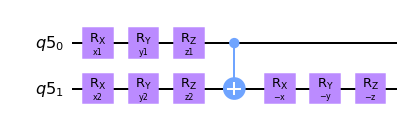

In [12]:
two_qubit_pool(QuantumRegister(1), QuantumRegister(1)).decompose().draw('mpl')

### Quantum Convolution

The quantum convolution is defined as the application of a two-qubit parameterized unitary to every pair of adjacent qubits with a stride of one.

In [13]:
def quantum_conv_circuit(bits): # Take care of rotations later
    """Quantum Convolution Layer 
    
    Parameters
    ----------
    bits: (QuantumRegister)
        Qiskit quantum register that will be used in the quantum circuit
    
    Returns
    -------
    qc: (QuantumCircuit)
        Qiskit circuit with the cascade of `two_qubit_unitary` applied
        
    to all pairs of qubits in `bits`   
    """
    
    qc = QuantumCircuit(bits)
    # The xyz variable below is meant as a workaround to parameter implementation and replacement
    xyz = ("x", "y", "z")
    k = 0 # variable to increment in order
    
    for first, second in zip(bits[0::2], bits[1::2]):
        i = first.index
        j = second.index
        ### Creating parameters to avoid duplicate names because they raises a Circuit Error ###
        k+=1
        q1_val = tuple([r + str(k) for r in xyz])
        q2_val = tuple([r + str(k + 1) for r in xyz])
        rzyx = tuple([t + str(k) for t in ("theta", "beta", "gamma")])
        k+=1
        rotations = {"q1": q1_val, "q2":q2_val, "rzyx":rzyx}
        qc.append(two_qubit_unitary(QuantumRegister(2), rotations).to_instruction(), [bits[i], bits[j]])
    
    ### Second loop for the second two_qubit unitary
    abc = ("a", "b", "c")
    p = 0
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        i = first.index
        j = second.index
        ### Creating parameters to avoid duplicate names because they raises a Circuit Error ###
        p+=1
        q1_val = tuple([r + str(p) for r in abc])
        q2_val = tuple([r + str(p + 1) for r in abc])
        rzyx = tuple([t + str(p) for t in ("mu", "nu", "eps")])
        p+=1
        rotations = {"q1": q1_val, "q2":q2_val, "rzyx":rzyx}
        qc.append(two_qubit_unitary(QuantumRegister(2), rotations).to_instruction(), [bits[i], bits[j]])
        
    return qc

/tmp/ipykernel_5908/1905655867.py:23: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  i = first.index
/tmp/ipykernel_5908/1905655867.py:24: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  j = second.index
/tmp/ipykernel_5908/1905655867.py:38: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  i = first.index
/tmp/ipykernel_5908/1905655867.py:39: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  j = second.index


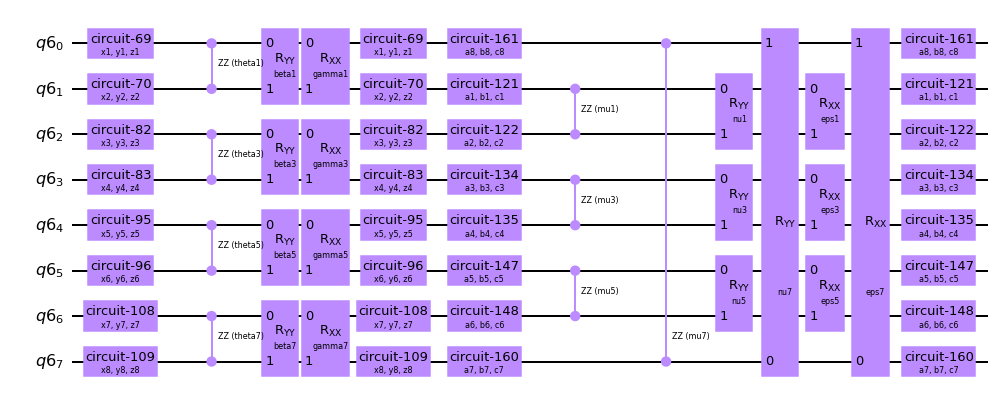

In [14]:
quantum_conv_circuit(QuantumRegister(8)).decompose().draw('mpl')

### Quantum Pooling Layer

The quantum pooling layer pools from N qubits to N/2 qubits using the two-qubit pool operation defined above.

In [15]:
def quantum_pool_circuit(bits):
    """A layer that specifies a quantum pooling operation.
    A Quantum pool tries to learn to pool the relevant information from two
    qubits onto 1.
    
    Parameters
    ----------
    bits: (QuantumRegister)
        Qiskit quantum register
        
    Returns
    -------
    circuit: (QuantumCircuit)
        Qiskit quantum circuit with the pooled qubits
    """
    
    circuit = QuantumCircuit(bits) # instantiating of the quantum circuit
    # The xyz variable below is mean't as a workaround to parameter implementation and replacement
    xyz = ("x", "y", "z")
    k = 0 # variable to increment in order
    
    assert len(bits) % 2==0, "The number of qubits in the register should be even"
    
    split = len(bits) // 2 # taking half of the quantum register's length

    for source, sink in zip(bits[:split], bits[split:]):
        
        i = source.index # getting source qubit index
        j = sink.index # sink qubit index

        ### Creating parameters to avoid duplicate names because they raises a Circuit Error ###
        k+=1
        q1_val = tuple([r + str(k) for r in xyz])
        invq_val = tuple(["-" + r + str(k) for r in xyz])
        q2_val = tuple([r + str(k + 1) for r in xyz])
        k+=1 # k is incremented twice because q2_val takes the value (k + 1) at k round

        tqb = two_qubit_pool(QuantumRegister(1), QuantumRegister(1), 
                             {"q1": q1_val, "q2":q2_val, "invq":invq_val})
        circuit.append(tqb.to_instruction(),
                       [bits[i], bits[j]])
    return circuit

/tmp/ipykernel_5908/872942377.py:28: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  i = source.index # getting source qubit index
/tmp/ipykernel_5908/872942377.py:29: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  j = sink.index # sink qubit index


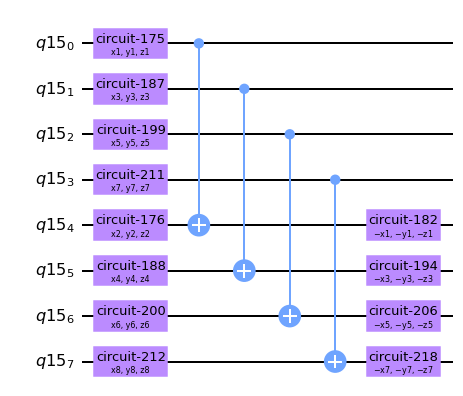

In [16]:
test_bits = QuantumRegister(8)
quantum_pool_circuit(test_bits).decompose().draw('mpl')